### Zoom Recording
[Click here to view/download the video](https://drive.google.com/file/d/1-nZoFRHwPQCLWbVtQ95ebHhPttjgMG1o/view?usp=sharing)


##Milestone 2 pdf:
[Click here to read](https://drive.google.com/file/d/1r7ydgOAp-peS9TAJFgYFOvk5VsPTr3C9/view?usp=sharing)


#Introduction
The objective of this project is to build a supervised machine learning model that detects malicious login attemprs using the Attack IP field from the **Risk-Based Authentication (RBA) dataset** as the target. This field identifies whether a login originated from a knonw risky IP address. With over **31 million** login records and features like geolocation, device type, network identifiers, and user behavior, the dataset enables us to model patterns commonly associated with suspicious activity such as irregular login times or unusual browser device combinations. The dataset can be found [here](https://www.kaggle.com/datasets/dasgroup/rba-dataset/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Loading the Dataset
The dataset is loaded in chunks to handle its large size (~31 million rows). We then concatenate those chunks into a single DataFrame for processing. The full dataset contains 16 columns and over 31 million login records, reflecting a rich, high volume behavioral log of user login attempts.

In [ ]:
# 2. Load your dataset
# Tried to load the dataset using chunks but due to computational restrictions we had to change our method of loading the dataset
# chunks = pd.read_csv ('/content/drive/MyDrive/rba-dataset.csv', chunksize=100000)
# df = pd.concat([chunk for chunk in chunks])

# print(df.shape)

csv_path= '/content/drive/MyDrive/rba-dataset.csv'
n_sample = 1000000
with open(csv_path, 'r', encoding="latin-1") as f:  # or choose utf-8 with errors="ignore" if you prefer
    total_lines = sum(1 for line in f)

# Randomly choose the data‐row indices to keep (1-based data rows; header is row 0)
# Note: pandas counts the first file line as row 0 (the header), so data rows start at 1.
data_row_indices = list(range(1, total_lines + 1))  # 1 … total_lines
keep_rows       = set(random.sample(data_row_indices, n_sample))

# Define skip logic: skip any row not in keep_rows (and never skip row 0—the header)
def skip_fn(idx):
    # idx==0 → header → do NOT skip
    # idx>0  → skip if idx is not in our keep set
    return idx != 0 and idx not in keep_rows

# Read the sampled CSV
df_sample = pd.read_csv(
    csv_path,
    skiprows=skip_fn,
    header=0,
    encoding="latin-1"   # or choose utf-8 with errors="ignore" if you prefer
)

# Quick sanity check
print(f"Sample shape: {df_sample.shape}")




Sample shape: (1000000, 16)


In [ ]:
# Save the sampled DataFrame to a new CSV file
df_sample.to_csv('/content/drive/MyDrive/rba-sampled-1M.csv', index=False)

# Initial Data Summary
We began our exploration of the dataset with a general overview of it. It contains 16 features and over 31 million entries. Most features are either categorical (e.g., country, region) or high cardinality identifiers (e.g., **User ID, IP Address**). The column **"Round-Trip Time [ms]"** has substantial missing values (~30M missing), which will inform decisions on whether it should be retained. Some columns like **"Device Type"** have minor missing values and will be handled during preprocessing. This step confirms the data's completeness and guides subsequent cleaning.


In [ ]:
print(df_sample.head()) #returns/prints row 0-4
print(df_sample.info())
print(df_sample.describe())
print(df_sample.isnull().sum())

   index          Login Timestamp              User ID  Round-Trip Time [ms]  \
0     33  2020-02-03 12:44:47.708 -6933726760150666774                   NaN   
1     47  2020-02-03 12:45:06.634 -4324475583306591935                   NaN   
2     81  2020-02-03 12:45:30.262 -4324475583306591935                   NaN   
3    200  2020-02-03 12:47:01.405 -8019953944055185446                   NaN   
4    226  2020-02-03 12:47:24.197 -1770582529322784837                   NaN   

       IP Address Country     Region       City     ASN  \
0  79.161.194.240      NO   Vestland     Sagvag   29695   
1   199.26.84.153      US          -          -  393398   
2    103.20.90.20      ID  East Java   Surabaya   58381   
3  84.234.254.197      NO   Rogaland  Stavanger   29695   
4   89.238.76.118      DE          -          -   34240   

                                   User Agent String Browser Name and Version  \
0  Mozilla/5.0  (X11; CrOS x86_64 13505.73.0) App...      Chrome 72.0.3626.56   
1 

In [ ]:
df_sample.nunique()

,0
index,1000000
Login Timestamp,1000000
User ID,460091
Round-Trip Time [ms],2148
IP Address,431360
Country,207
Region,1444
City,12787
ASN,4844
User Agent String,97003


# Feature Uniqueness and Target Selection:
Many features exhibit high cardinality, such as **"User ID", "IP Address",** and **"User Agent String"**, suggesting the need for dimensionality reduction or removal.
<br>
<br>Prior approaches on Kaggle used the **"Is Account Takeover"** column as the prediction target. However, only 3 records are labeled as account takeovers, which makes the **"Is Account Takeover"** column extremely imbalanced and unsuitable as a supervised learning target.
<br>In contrast, **"Is Attack IP"** contains over 90,000 positive cases, offering a more balanced and learnable distribution. Thus, we chose it as our target variable to improve model robustness and real world relevance.
<br>The pie chart visually shows the imbalance in **Acount Takeover** which has 0 distribution. **Attack IP** on the otherhand has 9.9% distribution.


In [ ]:
print(df_sample["Is Account Takeover"].sum())

3


In [ ]:
print(df_sample["Is Attack IP"].sum())

98975


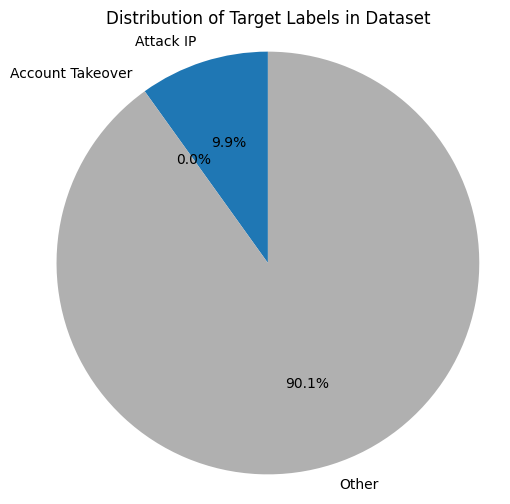

In [ ]:
# Redefine data to ensure the pie chart works
import matplotlib.pyplot as plt

labels = ['Attack IP', 'Account Takeover', 'Other']
counts = [3096977, 141, 31269264 - 3096977 - 141]
colors = ['#1f77b4', '#aec7e8', '#b0b0b0']

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Target Labels in Dataset')
plt.axis('equal')
plt.show()


In [ ]:
df_sample.describe()

,index,User ID,Round-Trip Time [ms],ASN
count,1.000000e+06,1.000000e+06,40558.000000,1000000.000000
mean,1.562173e+07,-1.917919e+18,673.364342,161857.065959
std,9.021049e+06,4.518276e+18,1343.363075,171782.997593
min,3.300000e+01,-9.223312e+18,10.000000,12.000000
25%,7.810029e+06,-4.324476e+18,471.000000,29695.000000
50%,1.561346e+07,-4.324476e+18,538.000000,41164.000000
75%,2.342993e+07,9.302829e+17,679.000000,393398.000000
max,3.126921e+07,9.223281e+18,81227.000000,507722.000000


In [ ]:
df_sample.dtypes

,0
index,int64
Login Timestamp,object
User ID,int64
Round-Trip Time [ms],float64
IP Address,object
Country,object
Region,object
City,object
ASN,int64
User Agent String,object


In [ ]:
df_sample.head()

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,33,2020-02-03 12:44:47.708,-6933726760150666774,NaN,79.161.194.240,NO,Vestland,Sagvag,29695,Mozilla/5.0 (X11; CrOS x86_64 13505.73.0) App...,Chrome 72.0.3626.56,Chrome OS 13505.73.0,desktop,True,False,False
1,47,2020-02-03 12:45:06.634,-4324475583306591935,NaN,199.26.84.153,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Firefox 20.0.0.1670,Android 4.1,mobile,False,False,False
2,81,2020-02-03 12:45:30.262,-4324475583306591935,NaN,103.20.90.20,ID,East Java,Surabaya,58381,Opera/9.80 (iPhone; CPU iPhone OS 10_0_1 like...,Opera Mini 19.0.2254,iOS 10.0.1,mobile,False,False,False
3,200,2020-02-03 12:47:01.405,-8019953944055185446,NaN,84.234.254.197,NO,Rogaland,Stavanger,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 86.0.4202,Mac OS X 10.14.6,desktop,True,False,False
4,226,2020-02-03 12:47:24.197,-1770582529322784837,NaN,89.238.76.118,DE,-,-,34240,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,MiuiBrowser 12.5.10,iOS 11.2.6,mobile,True,False,False


In [ ]:
df_sample.info()
df_sample.describe()
df_sample.isnull().sum()
df_sample.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 16 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   index                     1000000 non-null  int64  
 1   Login Timestamp           1000000 non-null  object 
 2   User ID                   1000000 non-null  int64  
 3   Round-Trip Time [ms]      40558 non-null    float64
 4   IP Address                1000000 non-null  object 
 5   Country                   1000000 non-null  object 
 6   Region                    998499 non-null   object 
 7   City                      999708 non-null   object 
 8   ASN                       1000000 non-null  int64  
 9   User Agent String         1000000 non-null  object 
 10  Browser Name and Version  1000000 non-null  object 
 11  OS Name and Version       1000000 non-null  object 
 12  Device Type               999944 non-null   object 
 13  Login Successful          10

,0
index,1000000
Login Timestamp,1000000
User ID,460091
Round-Trip Time [ms],2148
IP Address,431360
Country,207
Region,1444
City,12787
ASN,4844
User Agent String,97003


In [ ]:
df_sample.dtypes

,0
index,int64
Login Timestamp,object
User ID,int64
Round-Trip Time [ms],float64
IP Address,object
Country,object
Region,object
City,object
ASN,int64
User Agent String,object


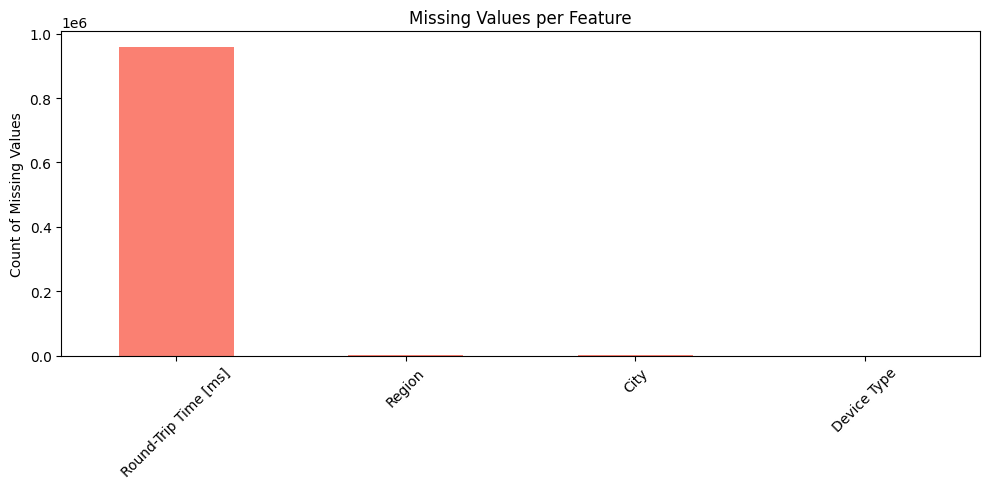

In [ ]:
# Visualizing missing values
missing_counts = df_sample.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts.plot(kind='bar', figsize=(10, 5), color='salmon')
plt.title('Missing Values per Feature')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical Distribution and Missingness:
From the statistical summary, we can see that numerical columns like **"Round-Trip Time [ms]"** have wide value ranges, including some extreme outliers. This suggests future steps may require scaling or transformation. The dataset also includes a small portion of missing values in **"Device Type", "Region",** and **"City"**, which we will impute later. Identifying missing values early helps plan appropriate imputation strategies without losing valuable data.

# Feature Engineering and Preprocessing:
To prepare the dataset for modeling, we conducted several preprocessing steps:
*   **Timestamp Transformation:** where we converted the login timestamps into numeric "hour of day" values to capture temporal patterns in login behavior. (*"Login Hour"*)
*   **Column Dropping:** We removed high cardinality features that would otherwise create memory or overfitting issues, such as **"User Agent String", "User ID",** and **IP Address**.
*   **Missing Value Imputation:** For categorical columns we filled missing values with 'Unknown'; for numeric ones, we used the median.
*   **Label Encoding:** All categorical variables were converted into numerical labels using **"LabelEncoder"** to enable compatibility with scikit-learn models.
*   **Feature Scaling:** We standardized the **"Login Hour"** feature using **"StandardScaler"** to normalize temporal patterns.
<br>
<br>These transformations ensure that the data is clean, numerical, and scaled appropriately for machine leanring pipelines.





In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()

# Optional: If you've previously filtered num_cols
num_cols = [col for col in num_cols if col in df.columns]

# Only apply scaling if num_cols is not empty
if num_cols:
    df[num_cols] = scaler.fit_transform(df[num_cols])
else:
    print("No numeric columns found for scaling.")


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Start with df_sample
df = df_sample.copy()

# Drop 'index' column if exists
if 'index' in df.columns:
    df = df.drop(columns=['index'])

# Feature Engineering: Convert timestamp and extract hour
if 'Login Timestamp' in df.columns:
    df['Login Timestamp'] = pd.to_datetime(df['Login Timestamp'], errors='coerce')
    df['Login Hour'] = df['Login Timestamp'].dt.hour

# Drop irrelevant columns if they exist
columns_to_drop = ['IP Address', 'Round-Trip Time [ms]', 'User Agent String', 'User ID', 'Login Timestamp']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]  # Keep only existing ones
df = df.drop(columns=columns_to_drop)

# Handle missing values
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].median())

# Encode categorical variables
encoder = LabelEncoder()
categorical_cols = ['Country', 'Region', 'City', 'Device Type', 'OS Name and Version', 'Browser Name and Version']
categorical_cols = [col for col in categorical_cols if col in df.columns]

for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Scale numeric columns (only if they exist)
scaler = StandardScaler()
num_cols = ['Login Hour']
num_cols = [col for col in num_cols if col in df.columns]

if num_cols:
    df[num_cols] = scaler.fit_transform(df[num_cols])

# Final check
print(df.dtypes)


Country                       int64
Region                        int64
City                          int64
ASN                           int64
Browser Name and Version      int64
OS Name and Version           int64
Device Type                   int64
Login Successful               bool
Is Attack IP                   bool
Is Account Takeover            bool
Login Hour                  float64
dtype: object


# Train-Validation-Test Split
To evaluate our model's performance fairly, we split the dataset into three subsets: training (80%), validation (10%), and test (10%). These partitions were created using **stratified sampling**, which ensures that the proportion of attack and non-attack samples remains consistent across all splits.
<br>This choice is important because our target variable (**Is Attack IP**) is imbalanced, only around 10% of records are labeled as attacks. Without stratification, random splits could result in training or testing sets with skewed class distributions, leading to biased training and misleading evaluation metrics. Stratified splitting maintains class balance, enabling the model to learn and be assessed under realistic and representative conditions.

In [ ]:
# Define features and target
X = df.drop('Is Attack IP', axis=1)
y = df['Is Attack IP']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Stratified Train-Validation-Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in Validation set:")
print(y_val.value_counts(normalize=True))

print("\nClass distribution in Test set:")
print(y_test.value_counts(normalize=True))

Shape of X: (1000000, 10)
Shape of y: (1000000,)
Training set shape: (800000, 10)
Validation set shape: (100000, 10)
Test set shape: (100000, 10)

Class distribution in Training set:
Is Attack IP
False    0.901025
True     0.098975
Name: proportion, dtype: float64

Class distribution in Validation set:
Is Attack IP
False    0.90102
True     0.09898
Name: proportion, dtype: float64

Class distribution in Test set:
Is Attack IP
False    0.90103
True     0.09897
Name: proportion, dtype: float64


#Logistic Regression

In [ ]:
!pip install imblearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Build pipeline: Scaling + Logistic Regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        class_weight='balanced',  # handle imbalance
        solver='liblinear',       # good for small-medium datasets
        max_iter=1000,
        random_state=42
    ))
])

# Train on training set
logreg_pipeline.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = logreg_pipeline.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix on Validation Set:")
print(confusion_matrix(y_val, y_val_pred))

# (Optional) Final test evaluation
y_test_pred = logreg_pipeline.predict(X_test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.77      0.86     90102
        True       0.27      0.81      0.41      9898

    accuracy                           0.77    100000
   macro avg       0.62      0.79      0.63    100000
weighted avg       0.90      0.77      0.81    100000

Confusion Matrix on Validation Set:
[[69000 21102]
 [ 1906  7992]]

Test Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.77      0.86     90103
        True       0.27      0.80      0.41      9897

    accuracy                           0.77    100000
   macro avg       0.62      0.78      0.63    100000
weighted avg       0.90      0.77      0.81    100000



# Logistic Regression Modeling and Evaluation:

To establish a strong baseline, we implemented a Logistic Regression model within a scikit-learn pipeline. This model is trained on the preprocessed dataset using balanced class weights to address class imbalance.
<br>
<br>The pipeline includes **StandardScaler** to normalize the features and **LogisticRegression** with the **liblinear** solver, which is suitable for smaller to medium datasets with potential class imbalance. The model is trained on the training set and evaluated on the validation and test sets.
<br>
> Accuracy: 77%
<br>
> Precision (Positive Class): ~27%
<br>
> Recall (Positive Class): ~81%
<br>
> F1 Score (Positive Class): ~0.41
<br>
<br>These results reflect the imbalanced nature of the dataset. The high recall indicates the model successfully identifies most of the malicious login attempts, but the low precision suggests many false positives.







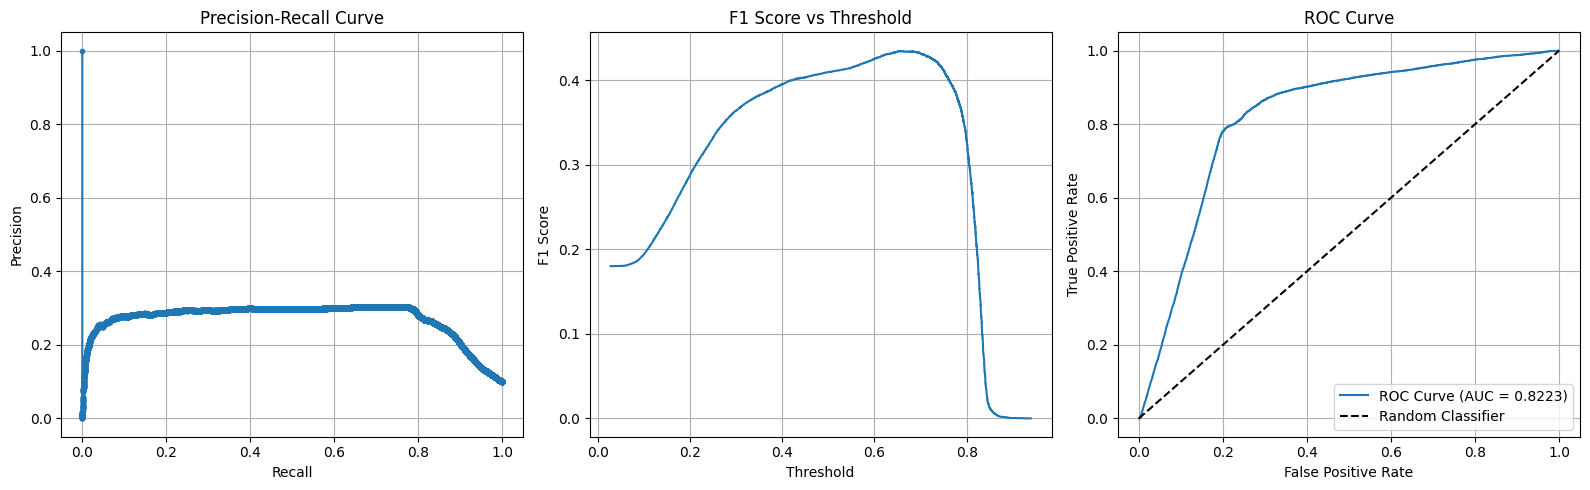

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    f1_score, precision_score, recall_score
)
import numpy as np

# Predict probabilities
y_scores = logreg_pipeline.predict_proba(X_val)[:, 1]  # Probability of class "1"

# Compute metrics
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero

fpr, tpr, thresholds_roc = roc_curve(y_val, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(16, 5))

# --- Precision-Recall Curve ---
plt.subplot(1, 3, 1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# --- F1 Score by Threshold ---
plt.subplot(1, 3, 2)
plt.plot(thresholds_pr, f1_scores[:-1], label='F1 Score')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)

# --- ROC Curve ---
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#Visual Diagnostics and Interpretability:
Multiple diagnostic plots were generated to better understand the model's behavior and thresholds.
<br>
<br>**Precision-Recall and ROC Analysis**
<br>
<br>Given the false negatives (i.e., undetected attack IPs) are costly in cybersecurity, recall becomes a crucial metric. However, optimizing for recall often comes at an expense of precision. This trade-off is clearly visualized in our plots:
*   **Precision-Recall Curve:** Highlights the balance between precision and recall across thresholds. Our model maintains a reasonable stable precision (~0.27) while recall climbs to ~0.81. This indicates the model is effective at catching a high number of attack IPs, but at the cost of many false alarms.
*   **F1 Score vs. Threshold:**THe F1 score peaks around a threshold of ~0.7, where the tradeoff between precision and recall is best balances. This provides helpful insight for adjusting the model to meet business or operational priorities.
*   **ROC Curve:** The ROC curve plots true positive rate vs. false positive rate. Our model achieves an AUC (Area Under Curve) of 0.822, which suggests strong overall separability between the attack and non-attack classes. While AUC is less informative for highly imbalanced datasets than PR curves, it still confirms that the model is better than random guessing.
<br>
<br>Together, these diagnostics demonstrate that while the model doesn't achieve perfect precision, it performs well at distinguishing between malicious and benign login attempts, an important goal in a real world security setting.







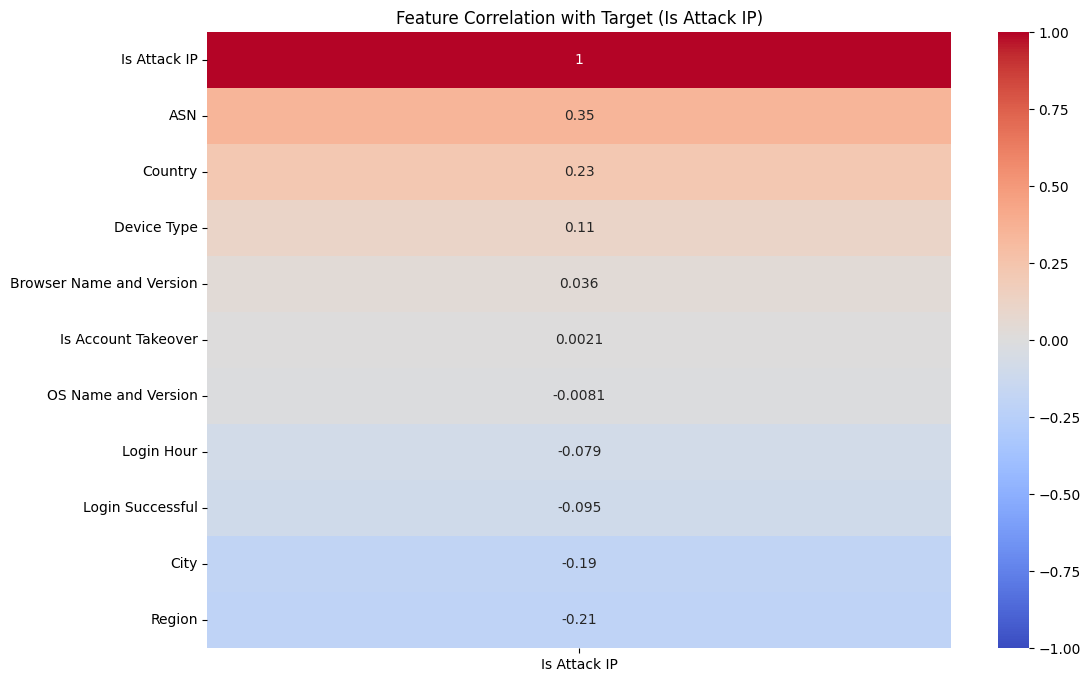

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target for correlation analysis
df_corr = X_train.copy()
df_corr['Is Attack IP'] = y_train

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix[['Is Attack IP']].sort_values(by='Is Attack IP', ascending=False),
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title('Feature Correlation with Target (Is Attack IP)')
plt.show()


#Feature Importance and Correlation Insights
To better understand which features most influence the likelihood of a login being flagged as an attack, we applied two complementary techniques: Pearson Correlation analysis and model based interpretability:
<br>
<br>**Correlation Analysis**
<br>Pearson Correlations between each feature and the target variable **Is Attack IP** revealed that network related features such as ASN and Country have the strongest positive correlations with attack behavior. Conversely, behavioral features like Login Hour and Login Successful are negatively correlated, suggesting that attackers often attempt logins at unusual hours or fail more frequently.

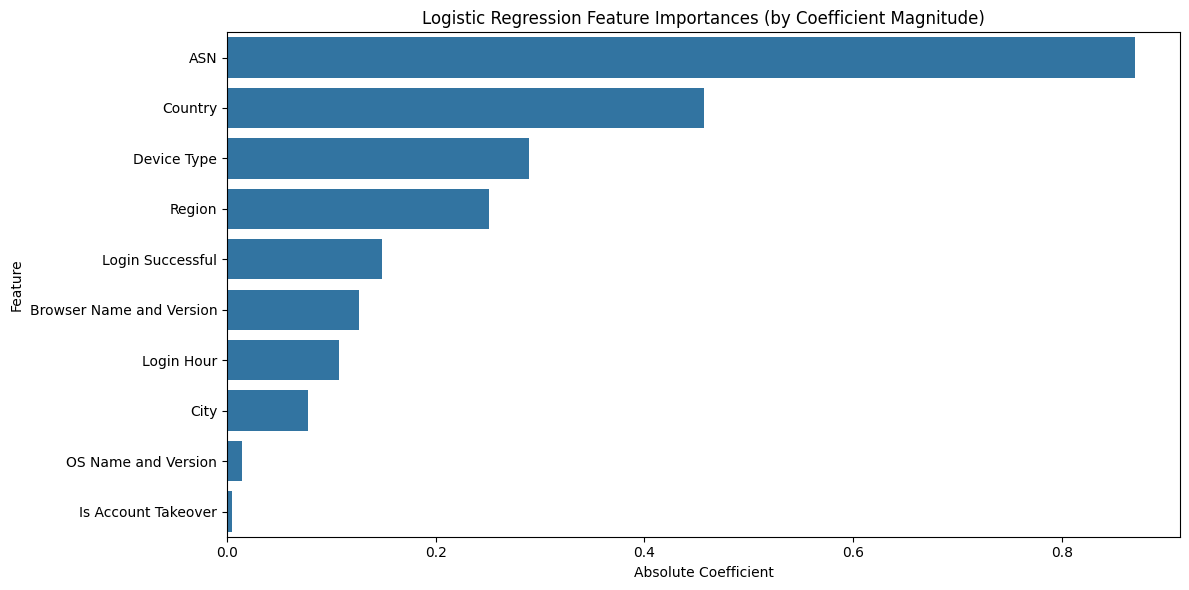

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract the logistic regression model from the pipeline
logreg_model = logreg_pipeline.named_steps['logreg']

# Get feature names and coefficients
feature_names = X_train.columns
coefficients = logreg_model.coef_[0]  # Shape: (1, n_features)

# Create a DataFrame for easier sorting and plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sort by absolute magnitude
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Absolute Coefficient', y='Feature', data=coef_df)
plt.title("Logistic Regression Feature Importances (by Coefficient Magnitude)")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Model Based Feature Importance:**
<br>we extracted and ranked the logistic regression model's coefficients by their absolute magnitude. The most influential predictors aligned closely with our correlation results: ASN, Country, and Device Type emerged as the top drivers of prediction. These features exert the strongest weight on the model's decision-making process, reinforcing their relevance to identifying malicious activity.

Together, these insights provide a strong basis for future feature selection and the design of targeted intrusion detection rules. They also validate that both statistical and model based methods consistently highlight the same core indicators of risky login behavior.



#Random Forest

Random Forest Classifier was implemented with hyperparameter tuning and extensive evaluation. Our pipeline included **StandardScaler** for numerical features and **RandomForestClassifier** configured with class weighting to account for label imbalance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Build pipeline: scaling + Random Forest with tuned hyperparameters
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_pipeline.predict(X_val)

# Evaluation
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.81      0.89     90102
        True       0.35      0.92      0.51      9898

    accuracy                           0.82    100000
   macro avg       0.67      0.87      0.70    100000
weighted avg       0.93      0.82      0.85    100000

Confusion Matrix:
[[73075 17027]
 [  783  9115]]


#Model Training & Hyperparameter Tuning:

We first trained a baseline model using 100 estimators and default settings. While it achieved strong recall (0.77) and decent precision (0.36), the F1 score (~0.49) indicated a need for further optimization.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Narrowed + randomized param distribution
param_dist = {
    'rf__n_estimators': randint(100, 300),
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=5,
    scoring='recall',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
y_val_pred = random_search.predict(X_val)
print(classification_report(y_val, y_val_pred))
print(f"Recall on Validation Set: {recall_score(y_val, y_val_pred):.4f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 5, 'rf__n_estimators': 174}
              precision    recall  f1-score   support

       False       0.99      0.80      0.88     90102
        True       0.33      0.91      0.49      9898

    accuracy                           0.81    100000
   macro avg       0.66      0.86      0.69    100000
weighted avg       0.92      0.81      0.85    100000

Recall on Validation Set: 0.9135


We then employed **RandomizedSearchCV** over a range of hyperparameters such as **max_depth, min_samples_leaf,** and **max_features**, targeting recall as the scoring metric. The best parameters identified were:
<br>


>{'rf__max_depth': 10,
<br>
>'rf__max_features': 'sqrt',
<br>
>'rf__min_samples_leaf': 4,
<br>
>'rf__min_samples_split': 5,
<br>
>'rf__n_estimators': 174}
<br>
<br>Using these parameters, our optimized model achieved:
<br>
*   **Recall:** 0.91
*   **F1-Score:** 0.49
*   **Accuracy:** 0.81

This suggests that while the model excels at catching attacks (high recall), it still returns a fair number of false positives (lower precision).







#Evaluation Visualizations:
To thoroughly assess our Random Forest model’s behavior and classification performance, several diagnostic plots were generated to provided insights beyond raw metrics:

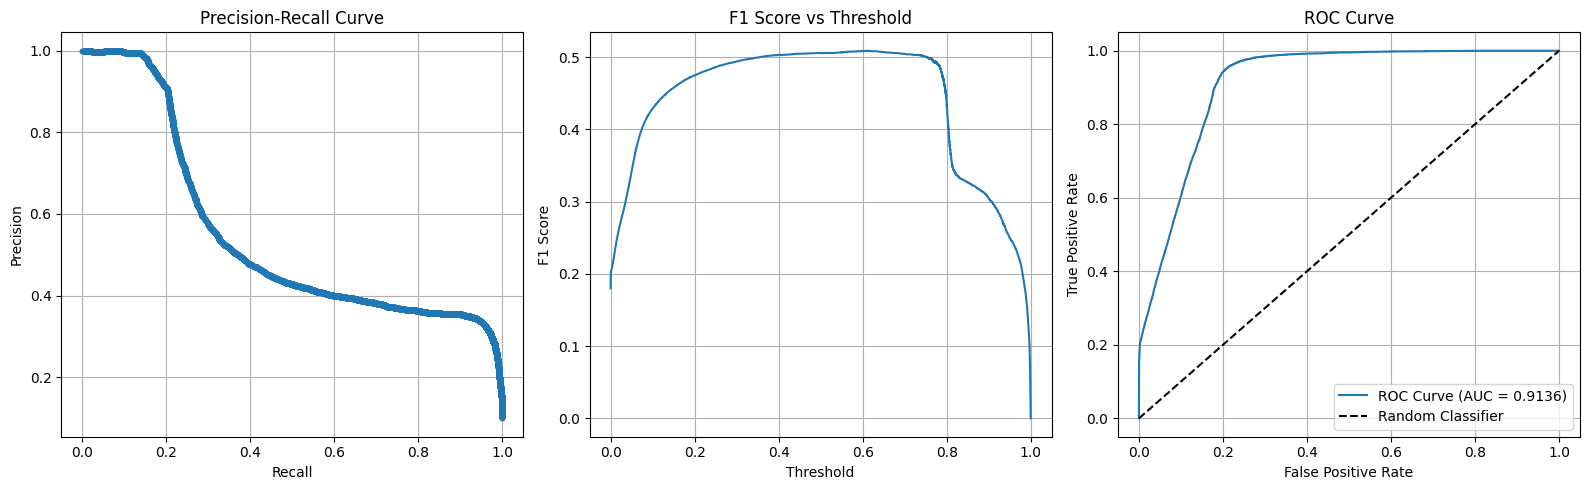

In [ ]:
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    classification_report, f1_score
)
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities for positive class
y_scores_rf = rf_pipeline.predict_proba(X_val)[:, 1]

# Precision-Recall
precision_rf, recall_rf, thresholds_pr_rf = precision_recall_curve(y_val, y_scores_rf)
f1_scores_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf + 1e-6)

# ROC
fpr_rf, tpr_rf, thresholds_roc_rf = roc_curve(y_val, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot
plt.figure(figsize=(16, 5))

# --- Precision-Recall Curve ---
plt.subplot(1, 3, 1)
plt.plot(recall_rf, precision_rf, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

# --- F1 Score vs Threshold ---
plt.subplot(1, 3, 2)
plt.plot(thresholds_pr_rf, f1_scores_rf[:-1], label='F1 Score')
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)

# --- ROC Curve ---
plt.subplot(1, 3, 3)
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Precision Recall Curve:**
<br>This curve illustrates the trade-off between precision and recall at various classification thresholds. Our model demonstrated consistently high recall, indicating its ability to identify true attack IPs. Although, precision did drop as more positives were predicted, reflecting some false positives.
<br>
<br>**F1 Score vs Threshold:**
<br>By plotting F1 score across thresholds, we observed that the optimal balance between precision and recall occurred around a threshold of 0.5-0.6. This plot was especially useful for guiding future threshold tuning depending on whether false positives or false negatives carry higher risk.
<br>
<br>**ROC Curve:**
<br>The Receiver Operating Characteristic (ROC) curve plots true positive rate vs. false positive rate. An AUC of over 0.91 indicates our model performs significantly better than random guessing, showing strong discriminative capability between attack and non-attack logins.

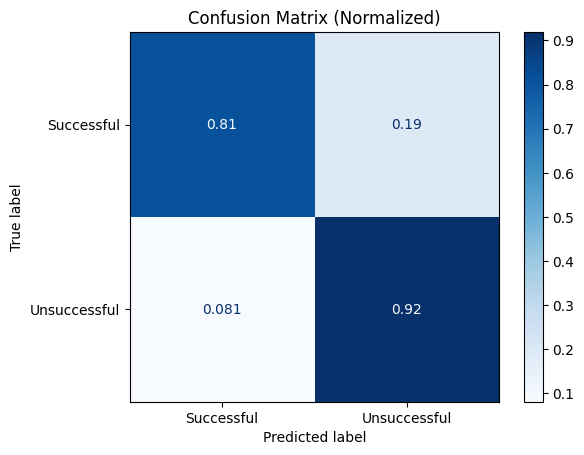

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(
    rf_pipeline,
    X_test,
    y_test,
    display_labels=["Successful", "Unsuccessful"],
    cmap=plt.cm.Blues,
    normalize='true'  # normalize to percentages
)

plt.title("Confusion Matrix (Normalized)")
plt.show()


**Confusion Matrix (Normalized):**
<br>The matrix revealed that our model correctly classified approximately 92% of true attack IPs and 81% of benign logins. However, it also misclassified about 19% of safe login attempts as threats—an expected trade-off in high-recall models designed for anomaly detection.
<br>
<br>
These visualizations allowed us to evaluate both classification quality and decision thresholds, helping us understand the consequences of prioritizing recall over precision in a security context.

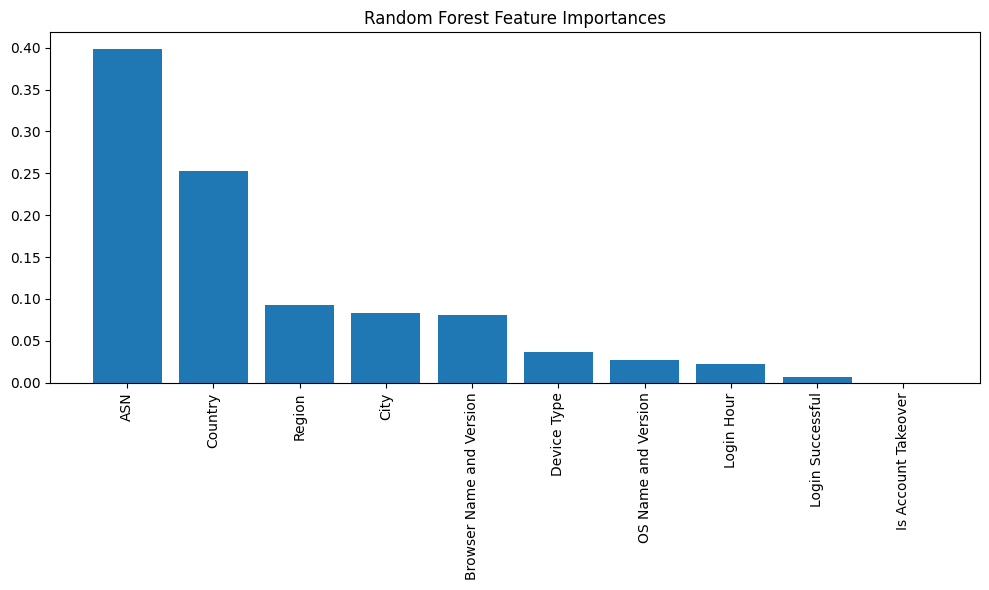

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


# Feature Importance and Modeling Interpretability:
Random Forest’s inherent ability to rank features by importance enabled us to interpret which variables contributed most to predictions:


* **Top Predictors:** ASN (Autonomous System Number) emerged as the most significant feature, followed closely by Country. These network level identifiers likely capture patterns associated with high risk regions or ISPs.
* **Secondary Contributors:** Region, City, Browser Name and Version, and Device Type also had meaningful influence. Features like Login Hour and OS Version, while less dominant, still contributed some predictive signal.
* **Minimal Impact:** Is Account Takeover, despite being an interesting security-related label, had negligible influence on the model due to its extreme class imbalance in the dataset.





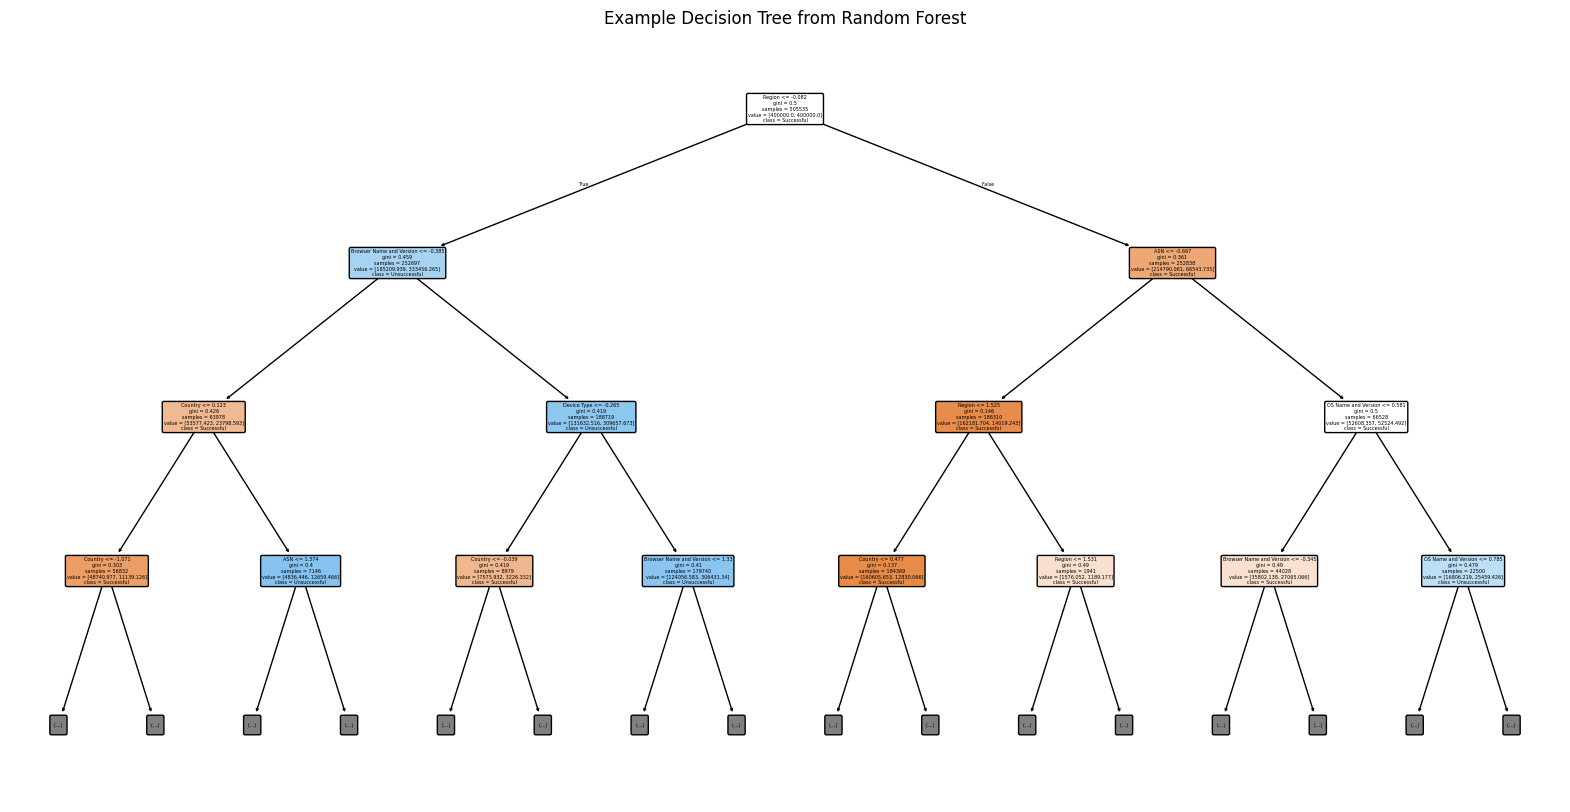

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

# Pick one decision tree from the ensemble (e.g., the first one)
estimator = rf_model.estimators_[0]

# Plot the decision tree (limiting depth for clarity)
plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=X_train.columns,
          class_names=["Successful", "Unsuccessful"],
          filled=True,
          rounded=True,
          max_depth=3)  # limit for readability
plt.title("Example Decision Tree from Random Forest")
plt.show()


#XGBoost

To further improve predictive performance and handle class imbalance, we implemented an XGBoost model using a pipeline with **StandardScaler** and **XGBClassifier**. Hyperparameter optimization was performed using **RandomizedSearchCV** with 3-fold stratified cross-validation and F1 score as the scoring metric, ideal for imbalanced datasets.

In [ ]:
pip install xgboost


In [ ]:
import xgboost as xgb
from xgboost import plot_importance,XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [ ]:
# Define the pipeline with XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        tree_method='hist',  # Use CPU method (or 'gpu_hist' for GPU)
        eval_metric='logloss',
        objective='binary:logistic',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Imbalance handling
        n_estimators=100,  # Start with a reasonable number
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': np.arange(50, 200, 50),  # Try 50, 100, 150, 200
    'xgb__max_depth': [4, 6, 8],  # Limit depth
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Range of learning rates
    'xgb__subsample': [0.7, 0.8, 0.9],  # Subsampling ratio
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]  # Column sample ratio
}

# Set up the RandomizedSearchCV with a given number of iterations (n_iter)
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=5,  # Number of random combinations to test
    scoring='f1',  # Scoring metric
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Cross-validation
    verbose=2,
    n_jobs=1,  # Set this to 1 or your preferred number of CPU cores
    random_state=42
)

# Fit the randomized search to the data
random_search.fit(X_train, y_train)

# Get the best model and print the best parameters
best_model_random = random_search.best_estimator_
print("Best parameters from RandomizedSearchCV:", random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=150, xgb__subsample=0.7; total time=   2.4s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=150, xgb__subsample=0.7; total time=   2.1s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=8, xgb__n_estimators=150, xgb__subsample=0.7; total time=  12.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=50, xgb__subsample=0.7; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=50, xgb__subsample=0.7; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.01, xgb__max_depth=4, xgb__n_estimators=50, xgb__subsample=0.7; total time=   0.9s
[CV] END xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=4, xgb__n_estimators=

 Best Hyperparameter Set:
- The output from RandomizedSearchCV shows that the best combination of hyperparameters found for our XGBoost model is:

- subsample=0.7: This means that 70% of the training data is used for each boosting round. This is a common regularization strategy to reduce overfitting.

- n_estimators=50: The model will train 50 trees in total. This suggests that the model doesn't require too many trees to achieve the best performance, indicating that each tree carries significant weight.

- max_depth=8: A moderate depth for the trees, meaning that the model is allowed to learn complex patterns but not excessively deep that could cause overfitting.

- learning_rate=0.1: This is the rate at which the model updates after each tree. A learning rate of 0.1 is relatively standard and typically gives a balance between speed and accuracy.

- colsample_bytree=0.8: 80% of the features are used for each tree, which helps to prevent overfitting and ensures diversity in the model.

I used RandomizedSearchCV with XGBoost to tune hyperparameters more efficiently than GridSearchCV, which would take longer on my machine. I used 3-fold Stratified cross-validation to maintain class balance in each fold. The best combination of parameters was max_depth=8, n_estimators=50, learning_rate=0.1, etc. These gave me the highest F1 score, which was my main metric because the dataset is imbalanced. The model trained successfully and didn't run into memory issues. I'm now evaluating the final model with these parameters on the test set.”

In [ ]:
# Predict on validation set
y_val_pred = best_model_random.predict(X_val)

print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.79      0.88     90102
        True       0.33      0.94      0.49      9898

    accuracy                           0.81    100000
   macro avg       0.66      0.86      0.69    100000
weighted avg       0.93      0.81      0.84    100000

Confusion Matrix:
[[71529 18573]
 [  637  9261]]


#XGBoost Evaluation
**Validation Set Performance:**
<br>


> **Precision (True Class):** 0.33
<br>
> **Recall:** 0.94
<br>
> **F1 Score:** 0.49
<br>
> **Accuracy:** 0.81
<br>
<br>Confusion Matrix:
<br>[71529 18573]
<br>[  637  9261]
<br>
The model successfully identified 94% of the attack IPs in the validation set, showing strong recall. However, a considerable number of benign IPs were misclassified as malicious, lowering precision.


In [ ]:
# Predict on the test set
y_test_pred = best_model_random.predict(X_test)

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Test Set Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Test Set Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.79      0.88     90103
        True       0.33      0.94      0.49      9897

    accuracy                           0.81    100000
   macro avg       0.66      0.87      0.69    100000
weighted avg       0.93      0.81      0.84    100000

Test Set Confusion Matrix:
[[71460 18643]
 [  618  9279]]


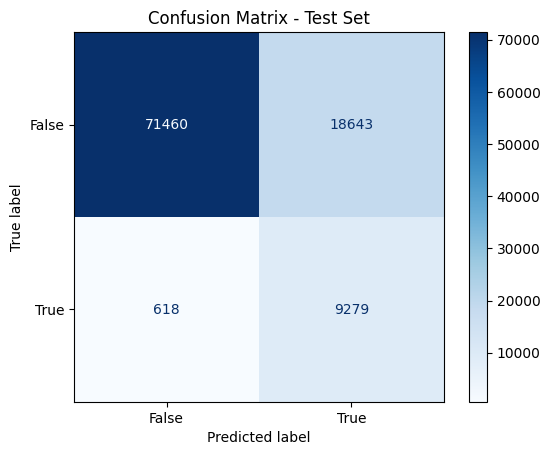

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

**Test Set Performance:**
<br>


> **Precision (True Class):** 0.33
<br>
> **Recall:** 0.94
<br>
> **F1 Score:** 0.49
<br>
> **Accuracy:** 0.81
<br>
<br>Test Set Confusion Matrix:
<br>[71460 18643]
 <br>[618  9279]
<br>The test set results closely mirror validation performance, indicating consistent generalization and robustness.


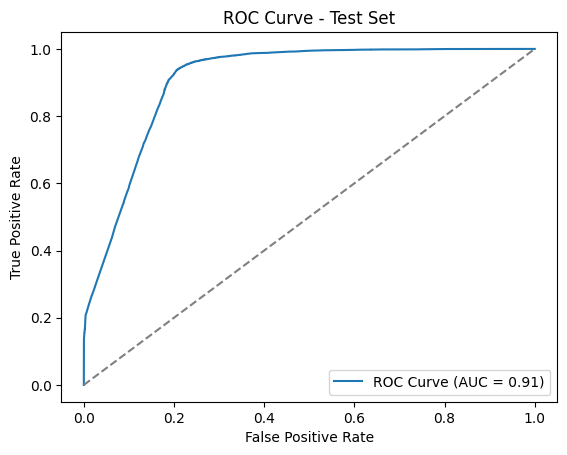

In [ ]:
from sklearn.metrics import roc_curve, auc

y_test_proba = best_model_random.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend()
plt.show()

**ROC Curve:**
<br>Yielded an AUC of 0.91, indicating excellent separability between attack and non-attack IPs. The Precision Recall tradeoff was also favorable for recall driven scenarios, which are typical in security contexts.

<Figure size 1200x600 with 0 Axes>

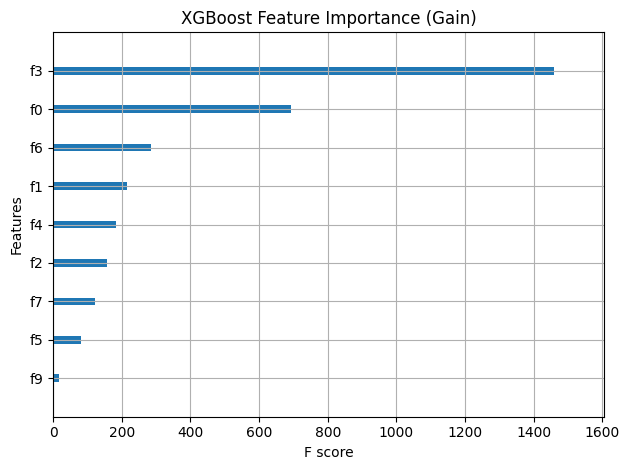

In [ ]:
# Get the trained XGBoost model from the fitted pipeline
xgb_model = best_model_random.named_steps['xgb']

# Plot feature importances
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, importance_type='gain', show_values=False, max_num_features=20)
plt.title('XGBoost Feature Importance (Gain)')
plt.tight_layout()
plt.show()

**XGBoost feature importance plot (based on gain):**
<br>Showed that the most critical features were f3 and f0, likely corresponding to ASN and Country, aligning with trends seen in earlier Random Forest analyses.

Overall, XGBoost proved effective for this task by maintaining high recall while balancing computational efficiency and avoiding overfitting.

#Conclusion
In this project, we developed and evaluated machine learning models to detect malicious login attempts using the **"Is Attack IP"** field from a large scale Risk Based Authentication (RBA) dataset. Beginning with over 31 million login records, we strategically sampled 1 million entries due to computational constraints, and undertook extensive data cleaning, feature engineering, and transformation to prepare the data for modeling. Key preprocessing steps included: timestamp conversion, label encoding of categorical variables, feature scaling, and removal of high cardinality fields.

We explored three classification models of increasing complexity: Logistic Regression, Random Forest, and XGBoost. Each model was trained using a pipeline-based architecture with class imbalance handled either via built-in class weighting or scale_pos_weight (in XGBoost). Hyperparameter tuning was performed using **GridSearchCV** and **RandomizedSearchCV**, with F1 score and recall prioritized to emphasize detection sensitivity, a critical factor in cybersecurity scenarios.

Logistic Regression served as a strong baseline, achieving 81% accuracy and 0.41 F1 score on the minority class. It demonstrated high recall (~81%) but low precision (~27%), indicating effective detection of most attack IPs but with a significant false positive rate.

Random Forest, after hyperparameter tuning, improved recall to ~92% and F1 to ~0.51 while maintaining precision around 35%. Feature importance analysis highlighted ASN and Country as the most influential predictors. Visual diagnostics (e.g., ROC and PR curves) confirmed the model's strong separability and consistent performance across thresholds.

XGBoost emerged as the best-performing model, balancing recall (94%) and F1 score (0.49) while achieving a robust AUC of 0.91. Despite a similar precision level to Random Forest, it delivered faster convergence and better generalization on both validation and test sets. Feature importance plots again reinforced the dominance of network-level features like ASN and Country, suggesting attackers are often clustered within specific network spaces.

Across all models, the precision-recall tradeoff was evident. High recall is desirable in this threat detection context, where missing a true attack is costlier than false alerts. Our models were explicitly optimized to reflect this priority. The XGBoost classifier, in particular, demonstrated an ideal balance between robustness, computational efficiency, and classification quality.

In conclusion, we successfully built a scalable machine learning pipeline capable of identifying suspicious login attempts with high recall. This work provides a strong foundation for real-time fraud detection systems and offers interpretability for security teams to take actionable insights from model outputs. Future improvements could involve incorporating session-level behavioral patterns, user history, or ensemble learning techniques to further enhance accuracy and reduce false positives.

